In [31]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
from cvxopt import matrix,solvers
solvers.options['show_progress'] = False
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

In [4]:
# Load the CSV file
data = pd.read_csv('list.csv')

# Get the list of stock tickers
tickers = data['Symbol'].tolist()

# Convert list of tickers into a string separated by spaces for yfinance
ticker_str = ' '.join(tickers)

In [7]:
stock_data = yf.download(ticker_str, start='1950-01-01', end='2024-12-31')
# Now, stock_data holds your pulled stock information, and you can work with it directly in Python
print(stock_data)

[*********************100%%**********************]  1003 of 1003 completed

2 Failed downloads:
['UHA-B', 'CWE-A']: Exception('%ticker%: No timezone found, symbol may be delisted')


Price        Adj Close                                                       \
Ticker               A         AA    AAL        AAP        AAPL        ABBV   
Date                                                                          
1962-01-02         NaN   1.541704    NaN        NaN         NaN         NaN   
1962-01-03         NaN   1.565285    NaN        NaN         NaN         NaN   
1962-01-04         NaN   1.565285    NaN        NaN         NaN         NaN   
1962-01-05         NaN   1.562337    NaN        NaN         NaN         NaN   
1962-01-08         NaN   1.509277    NaN        NaN         NaN         NaN   
...                ...        ...    ...        ...         ...         ...   
2024-04-29  139.589996  37.650002  13.98  75.419998  173.500000  161.520004   
2024-04-30  137.039993  35.139999  13.51  72.980003  170.330002  162.639999   
2024-05-01  138.690002  34.250000  13.58  73.029999  169.300003  161.720001   
2024-05-02  137.520004  35.939999  13.86  74.919998 

In [5]:
stock_data = pd.read_csv('stock_data.csv')

# Now, stock_data holds your pulled stock information, and you can work with it directly in Python
print(stock_data)

             Date           A         AA      AAL        AAP        AAPL  \
0      1962-01-02         NaN   1.541704      NaN        NaN         NaN   
1      1962-01-03         NaN   1.565285      NaN        NaN         NaN   
2      1962-01-04         NaN   1.565285      NaN        NaN         NaN   
3      1962-01-05         NaN   1.562337      NaN        NaN         NaN   
4      1962-01-08         NaN   1.509277      NaN        NaN         NaN   
...           ...         ...        ...      ...        ...         ...   
15687  2024-04-29  139.589996  37.650002  13.9800  75.419998  173.500000   
15688  2024-04-30  137.039993  35.139999  13.5100  72.980003  170.330002   
15689  2024-05-01  138.690002  34.250000  13.5800  73.029999  169.300003   
15690  2024-05-02  137.520004  35.939999  13.8600  74.919998  173.029999   
15691  2024-05-03  138.639999  36.669998  13.7886  76.447899  184.544998   

             ABBV        ABNB         ABT       ACGL  ...         YUM  \
0             

In [8]:
# Ensure that 'Adj Close' is at the same level as other columns if it's a MultiIndex
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data = stock_data['Adj Close']
else:
    stock_data = stock_data[['Adj Close']]

# Calculate logarithmic returns for each stock
log_returns = np.log(stock_data / stock_data.shift(1))

# Resample the data to monthly, and calculate the mean of the log returns
monthly_returns = log_returns.resample('M').mean()

# Calculate the mean of the monthly log returns for each stock
average_monthly_returns = monthly_returns.mean().sort_values(ascending=False)

# Get the top 25 stocks based on average monthly logarithmic returns
top_25_stocks = average_monthly_returns.head(25)

print(top_25_stocks)

C:\Users\franc\AppData\Local\Temp\ipykernel_38020\2105949717.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = log_returns.resample('M').mean()


Ticker
NLOP     0.008004
CR       0.003543
KLG      0.003533
CEG      0.003405
CAVA     0.003099
CNM      0.002710
NATL     0.002637
LLYVK    0.002535
CARR     0.002168
LLYVA    0.002140
ROKU     0.002029
TTD      0.001963
MRNA     0.001873
SWAV     0.001857
VLTO     0.001779
INSP     0.001763
BJ       0.001741
CART     0.001685
GFS      0.001653
PHIN     0.001639
CRWD     0.001620
KNSL     0.001618
VRT      0.001553
PINS     0.001551
GEHC     0.001545
dtype: float64


In [6]:
# Save the pulled data to a new CSV file
stock_data.to_csv('stock_data.csv')

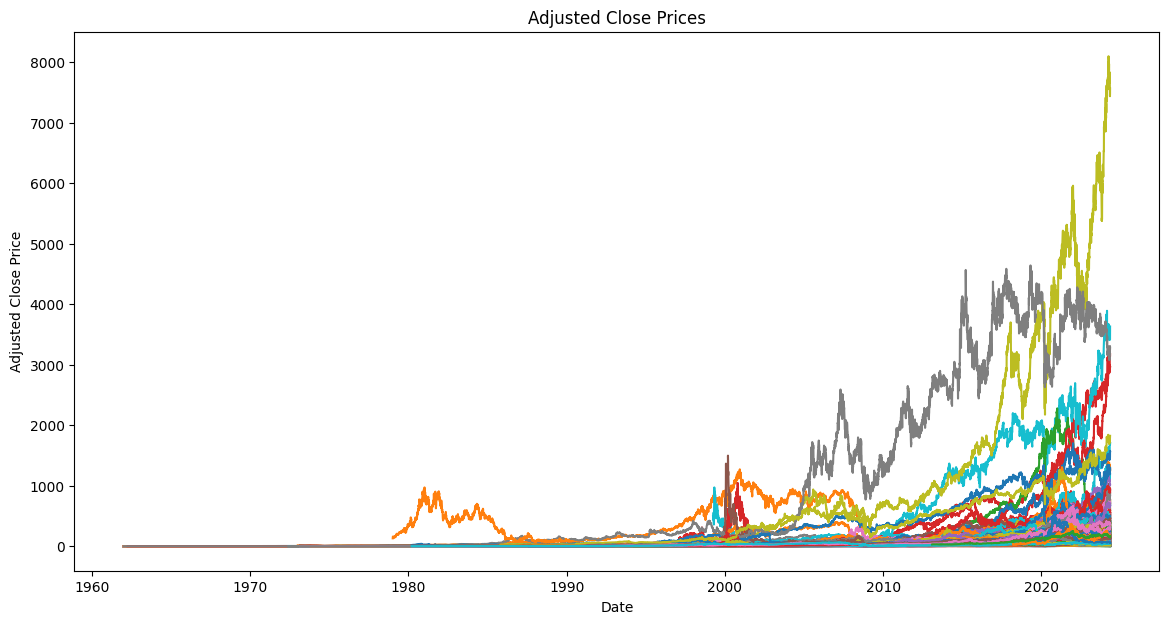

In [9]:
# Plotting each of the top 25 stocks' Adjusted Close prices
plt.figure(figsize=(14, 7))
for ticker in stock_data.columns:
    plt.plot(stock_data.index, stock_data[ticker], label=ticker)

plt.title('Adjusted Close Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()

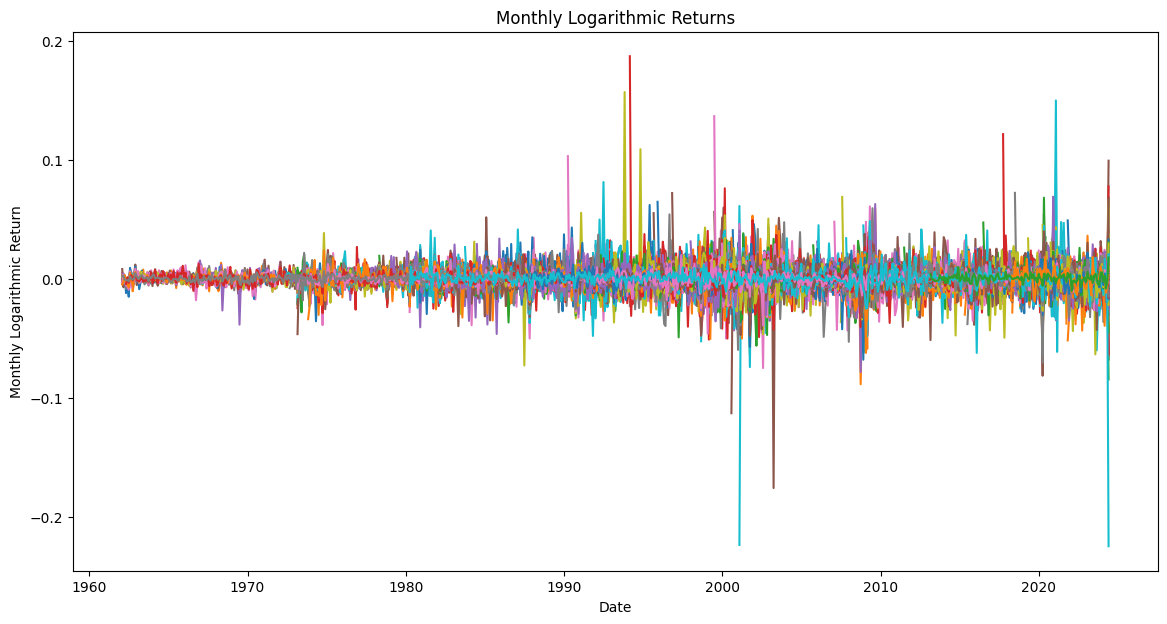

In [10]:
# Plotting the monthly returns for the top 25 stocks
plt.figure(figsize=(14, 7))
for ticker in monthly_returns.columns:
    plt.plot(monthly_returns.index, monthly_returns[ticker], label=ticker)

plt.title('Monthly Logarithmic Returns')
plt.xlabel('Date')
plt.ylabel('Monthly Logarithmic Return')
plt.show()

In [14]:
covariance_matrix = log_returns.cov()
correlation = log_returns.corr()

In [33]:
distances = np.sqrt((1 - correlation) / 2)
columns = log_returns.columns

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

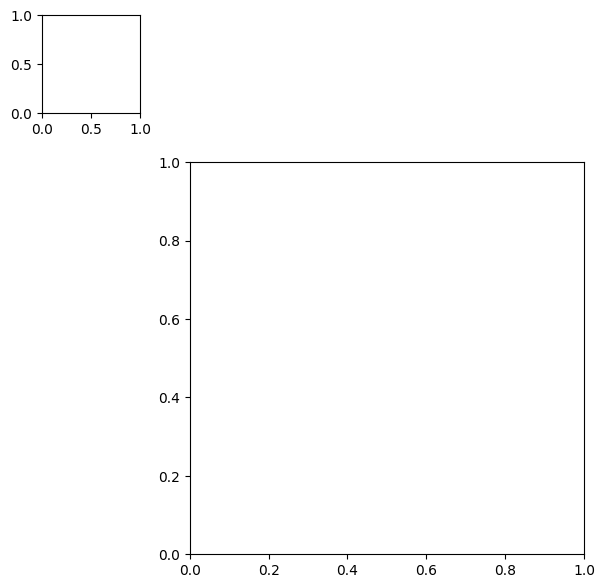

In [37]:
# Now using Seaborn's clustermap function to plot the correlation matrix
g = sns.clustermap(correlation, figsize=(7, 7), annot=True, cmap='coolwarm')
g.fig.suptitle('Correlation Matrix for Asset Returns', fontsize=20, va='bottom')  # Adjust the title position
plt.show()

In [7]:
# Define the periods for segmentation
periods = ['daily', 'weekly', 'monthly', 'quarterly', 'yearly']

# Print the statistics and correlation matrices for each period
for period in periods:
    print(f"Statistics for {period.capitalize()} Period:")
    print(statistics_tables[period])
    print("\n")  # Adding a newline for better readability between sections

    print(f"Correlation Matrix for {period.capitalize()} Period:")
    print(correlation_matrices[period])
    print("\n\n")  # Adding double newlines for spacing between periods

Statistics for Daily Period:


NameError: name 'statistics_tables' is not defined